In [19]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

2.3.0


A partir del fichero "US_Crime_Rates_1960_2014", se pide:

**1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.**

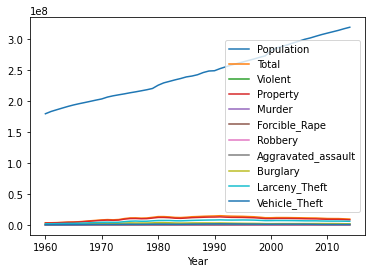

In [6]:
df = pd.read_csv("US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

In [7]:
to_train = df.loc[df.index[:-4]]
to_predict = df.loc[df.index[-4:]]

In [8]:
X_train = to_train.drop('Murder',axis=1)
y_train = to_train["Murder"]

**2. Crea una red neuronal no convolucional de 3 capas y 32, 32, 64 neuronas respectivamente. Entrénala con los datos desde 1960 hasta 2010. Usa los datos desde 2010 hasta 2014 para predecir la columna "Murder" (y). ¿Se aproxima al número real?**

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=32, input_dim = 10, activation="relu"))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dense(units=1, activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])

In [7]:
result = model.predict(to_predict.drop('Murder', axis = 1))
result

array([[11601790.],
       [11670840.],
       [11717618.],
       [11751895.]], dtype=float32)

In [8]:
class PrintLine(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('|', end='')

In [9]:
EPOCHS = 200

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model_history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintLine()])

|||||||||||||||||

In [10]:
print(f"Entrena durante {len(model_history.history['loss'])} epochs")

Entrena durante 17 epochs


In [11]:
loss, mae, mse = model.evaluate(X_train, y_train, verbose=2)

2/2 - 0s - loss: 309865185280.0000 - mae: 539313.0000 - mse: 309865185280.0000


In [12]:
model_history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

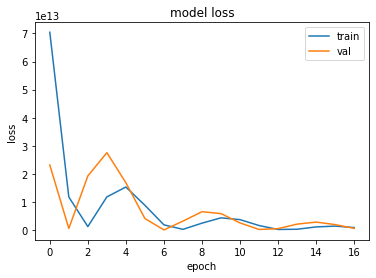

In [13]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

To get to understand your loss plot: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic 

In [14]:
X_predict = to_predict.drop("Murder", axis =1)

In [15]:
y_predict = to_predict.Murder
y_predict

Year
2011    14661
2012    14866
2013    14319
2014    14249
Name: Murder, dtype: int64

In [16]:
prediction = [e for array in model.predict(X_predict) for e in array]

In [17]:
prediction

[-861682.25, -875289.0, -904148.25, -937158.75]

In [18]:
predicciones = pd.DataFrame({"real": y_predict, "pred_3_layer": prediction})
predicciones

,real,pred_3_layer
Year,,
2011,14661,-861682.25
2012,14866,-875289.00
2013,14319,-904148.25
2014,14249,-937158.75


**3. Ahora, prueba 3 optimizadores diferentes, ¿se modifica el resultado? ¿cuál te ha dado mejores resultados?**
**4. Con el mejor optimizador modifica la función de activación a otra diferente. ¿Cuál ha dado mejor resultado?**

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

In [16]:
def train_model(model, epochs, X, y, verbose=0):
    EPOCHS = epochs
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model_history = model.fit(X, y, epochs=EPOCHS,
                    validation_split = 0.2, verbose=verbose, callbacks=[early_stop])
    return model_history

In [45]:
hiper_dict = {"act1":["relu", "linear", "sigmoid"],
              "act2":["relu", "linear", "sigmoid"],
              "act3":["relu", "linear", "sigmoid"],
              "act_output":["relu", "tanh", "softmax", "linear", "sigmoid"],
              "opt":["RMSprop", "adam", "SGD", "Adadelta"]}

In [51]:
def try_model_3(params, X, y, epochs):
    
    loss_dict = {}
    
    for act1 in params["act1"]:
        for act2 in params["act2"]:
            for act3 in params["act3"]:
                for act_output in params["act_output"]:
                    for opt in params["opt"]:
                        model = keras.models.Sequential()
                        model.add(keras.layers.Dense(units=32, input_dim = X.shape[1], activation=act1))
                        model.add(keras.layers.Dense(units=32, activation=act2))
                        model.add(keras.layers.Dense(units=64, activation=act3))
                        model.add(keras.layers.Dense(units=1, activation = act_output))
                        
                        model.compile(loss='mse',
                                    optimizer=opt,
                                    metrics=['mae', 'mse'])

                        history = train_model(model=model, epochs=epochs, X=X, y=y)
                        
                        loss_keys = ["act1", "act2", "act3", "act_output", "opt", "min_loss"]
                        loss_values = [act1, act2, act3, act_output, opt, min(history.history["loss"])]
                        for i, e in enumerate(loss_keys):
                            loss_dict.setdefault(e, []).extend([loss_values[i]])
                            
                                                                            
    return loss_dict

In [52]:
# en mi ordenador ha tardado 12.39 minutos en ejecutarse
start_time = time.time()
lossd = try_model_3(params= hiper_dict, X= X_train, y= y_train, epochs=100)
print(f"--- {(time.time() - start_time)/60} minutes ---")

c:\users\clara\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\clara\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\clara\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\clara\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\clara\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callback

--- 13.643802650769551 minutes ---


In [55]:
lossdf = pd.DataFrame(lossd)
lossdf

,act1,act2,act3,act_output,opt,min_loss
0,relu,relu,relu,relu,RMSprop,3.459116e+08
1,relu,relu,relu,relu,adam,3.438303e+08
2,relu,relu,relu,relu,SGD,1.159363e+15
3,relu,relu,relu,relu,Adadelta,3.438303e+08
4,relu,relu,relu,tanh,RMSprop,3.438010e+08
...,...,...,...,...,...,...
535,sigmoid,sigmoid,sigmoid,linear,Adadelta,3.437944e+08
536,sigmoid,sigmoid,sigmoid,sigmoid,RMSprop,3.437945e+08
537,sigmoid,sigmoid,sigmoid,sigmoid,adam,3.437948e+08
538,sigmoid,sigmoid,sigmoid,sigmoid,SGD,3.437945e+08


In [59]:
lossdf.to_csv("lossdf.csv", index= False)

----------------------------------------------------------------------------------------------------------------------------

In [9]:
lossdf_6 = pd.read_csv('lossdf.csv')

In [11]:
lossdf_6.sort_values(by= "min_loss")

,act1,act2,act3,act_output,opt,min_loss
234,linear,relu,sigmoid,linear,SGD,14940805.0
222,linear,relu,sigmoid,relu,SGD,20922666.0
114,relu,linear,sigmoid,linear,SGD,22972730.0
354,linear,sigmoid,sigmoid,linear,SGD,22977570.0
54,relu,relu,sigmoid,linear,SGD,22979298.0
...,...,...,...,...,...,...
202,linear,relu,linear,relu,SGD,NaN
214,linear,relu,linear,linear,SGD,NaN
254,linear,linear,relu,linear,SGD,NaN
262,linear,linear,linear,relu,SGD,NaN


In [14]:
lossdf_6[lossdf_6.min_loss == np.min(lossdf_6.min_loss)]

,act1,act2,act3,act_output,opt,min_loss
234,linear,relu,sigmoid,linear,SGD,14940805.0


**5. Ahora, haz que la red tenga 7 capas con 17,9,4,16,4,4,4 neuronas respectivamente. Utiliza la mejor función de activación y el mejor optimizador. ¿Esta red da mejor resultado? (Si da problema de memoria, prueba a quitar capas.)**

In [ ]:
'''
# add a checkpoint to save the lowest validation loss
filepath = 'tf2_mnist_model.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])
'''

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=17, input_dim = X_train.shape[1], activation='linear'))
model.add(keras.layers.Dense(units=9, activation='linear'))
model.add(keras.layers.Dense(units=4, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(units=4, activation='relu'))
model.add(keras.layers.Dense(units=4, activation='sigmoid'))
model.add(keras.layers.Dense(units=4, activation='sigmoid' ))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mse',
            optimizer='SGD',
            metrics=['mae', 'mse'])

history = train_model(model=model, epochs=100, X=X_train, y=y_train, verbose=1)

Epoch 1/100
2/2 [==============================] - 0s 201ms/step - loss: 337931744.0000 - mae: 17716.2168 - mse: 337931744.0000 - val_loss: 197206432.0000 - val_mae: 14027.6250 - val_mse: 197206432.0000
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 264289328.0000 - mae: 15518.9893 - mse: 264289328.0000 - val_loss: 135755088.0000 - val_mae: 11632.8369 - val_mse: 135755088.0000
Epoch 3/100
2/2 [==============================] - 0s 16ms/step - loss: 196529536.0000 - mae: 13163.3018 - mse: 196529536.0000 - val_loss: 92473312.0000 - val_mae: 9593.8057 - val_mse: 92473312.0000
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 147674656.0000 - mae: 11156.7559 - mse: 147674656.0000 - val_loss: 62371332.0000 - val_mae: 7870.1421 - val_mse: 62371332.0000
Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 111983360.0000 - mae: 9473.0176 - mse: 111983360.0000 - val_loss: 39134248.0000 - val_mae: 6221.0967 - val_mse: 39134248.0000


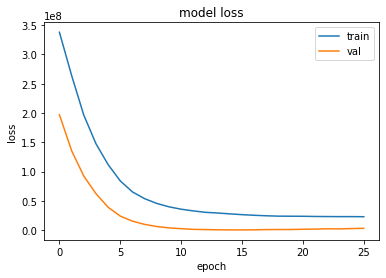

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()